In [1]:
import numpy as np
import time
from sklearn.neighbors import KDTree
from sklearn.utils import murmurhash3_32
import matplotlib.pyplot as plt

# Data Generation
def generate_data(N, D):
    return np.random.rand(N, D)

# Naive KNN Implementation
def naive_knn(X_train, X_test, K):
    distances = np.sqrt(((X_train[:, None, :] - X_test[None, :, :]) ** 2).sum(axis=2))
    neighbors = np.argsort(distances, axis=0)[:K].T
    return neighbors

# KD-Tree KNN Implementation
def kd_tree_knn(X_train, X_test, K):
    tree = KDTree(X_train)
    _, neighbors = tree.query(X_test, k=K)
    return neighbors

# LSH KNN Implementation
def lsh_knn(X_train, X_test, K, hash_bits=8, num_tables=5):
    # Initialize hash tables
    hash_tables = [{} for _ in range(num_tables)]
    
    def hash_function(point, num_bits):
        return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
    
    for idx, point in enumerate(X_train):
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            if h in hash_tables[t]:
                hash_tables[t][h].append(idx)
            else:
                hash_tables[t][h] = [idx]
    
    neighbors = []
    for point in X_test:
        candidates = set()
        for t in range(num_tables):
            h = hash_function(point, hash_bits)
            candidates.update(hash_tables[t].get(h, []))
        
        if candidates:
            candidate_points = X_train[list(candidates)]
            distances = np.sqrt(((candidate_points - point) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:K]
            neighbors.append([list(candidates)[i] for i in nearest_indices])
        else:
            neighbors.append([])
    return np.array(neighbors, dtype=object)

In [2]:
# Visualization of Neighbors and Partitions
def visualize_neighbors_and_partitions(X_train, X_test, neighbors, method_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Points')
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', label='Test Points')

    # Draw connections to neighbors
    for idx, test_point in enumerate(X_test):
        for neighbor_idx in neighbors[idx]:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]], 
                     [test_point[1], X_train[neighbor_idx, 1]], 'k--', alpha=0.5)

    plt.title(f"{method_name} KNN Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

In [3]:
import time

def compare_knn_variants_with_timing(N_list, D, K):
    results = []

    for N in N_list:
        X_train = generate_data(N, D)
        X_test = generate_data(10, D)  # Small test set

        # Naive KNN
        naive_train_start = time.time()
        # No training for naive KNN
        naive_train_time = time.time() - naive_train_start

        naive_test_start = time.time()
        naive_neighbors = naive_knn(X_train, X_test, K)
        naive_test_time = time.time() - naive_test_start

        # KD-Tree KNN
        kd_train_start = time.time()
        kd_tree = KDTree(X_train)  # Training phase
        kd_train_time = time.time() - kd_train_start

        kd_test_start = time.time()
        kd_neighbors = kd_tree.query(X_test, k=K)[1]  # Testing phase
        kd_test_time = time.time() - kd_test_start

        # LSH KNN
        lsh_train_start = time.time()
        # Build LSH hash tables
        def lsh_train(X_train, hash_bits=8, num_tables=5):
            hash_tables = [{} for _ in range(num_tables)]
            def hash_function(point, num_bits):
                return murmurhash3_32(point.tobytes()) & ((1 << num_bits) - 1)
            for idx, point in enumerate(X_train):
                for t in range(num_tables):
                    h = hash_function(point, hash_bits)
                    if h in hash_tables[t]:
                        hash_tables[t][h].append(idx)
                    else:
                        hash_tables[t][h] = [idx]
            return hash_tables

        hash_tables = lsh_train(X_train)
        lsh_train_time = time.time() - lsh_train_start

        lsh_test_start = time.time()
        lsh_neighbors = lsh_knn(X_train, X_test, K)
        lsh_test_time = time.time() - lsh_test_start

        # Store results
        results.append({
            'N': N,
            'naive_train_time': naive_train_time,
            'naive_test_time': naive_test_time,
            'kd_train_time': kd_train_time,
            'kd_test_time': kd_test_time,
            'lsh_train_time': lsh_train_time,
            'lsh_test_time': lsh_test_time
        })
    
    return results


N         Naive Train    Naive Test     KD-Tree Train  KD-Tree Test   LSH Train      LSH Test       
50        0.0000         0.0000         0.0010         0.0000         0.0010         0.0010         
200       0.0000         0.0000         0.0010         0.0000         0.0020         0.0010         
500       0.0000         0.0000         0.0010         0.0000         0.0020         0.0030         


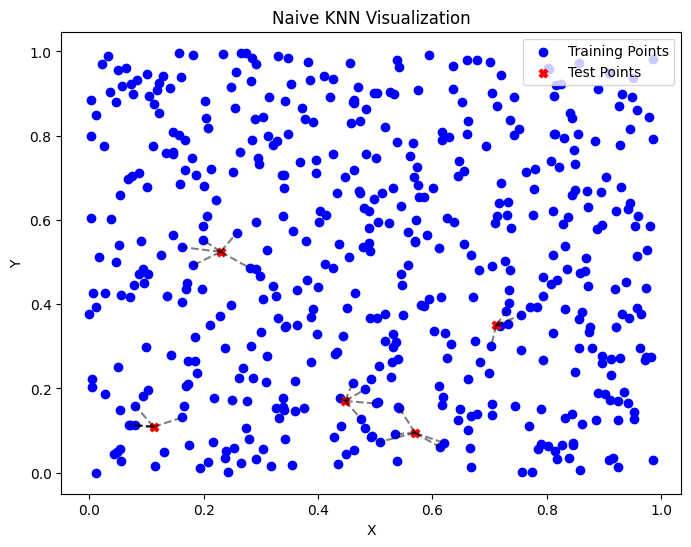

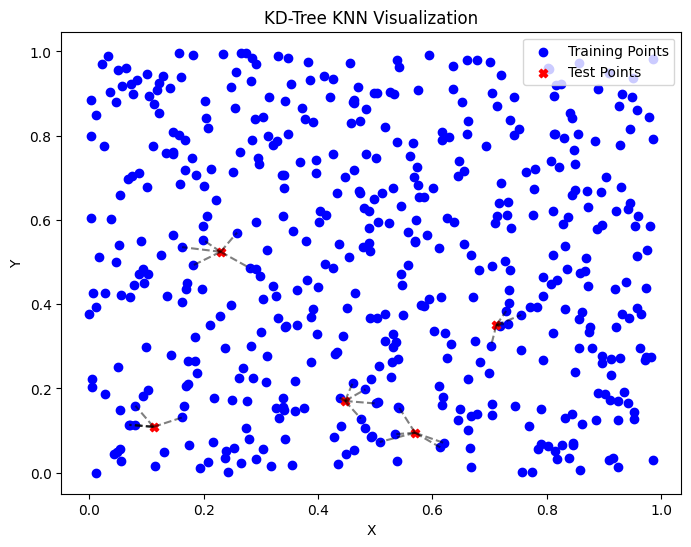

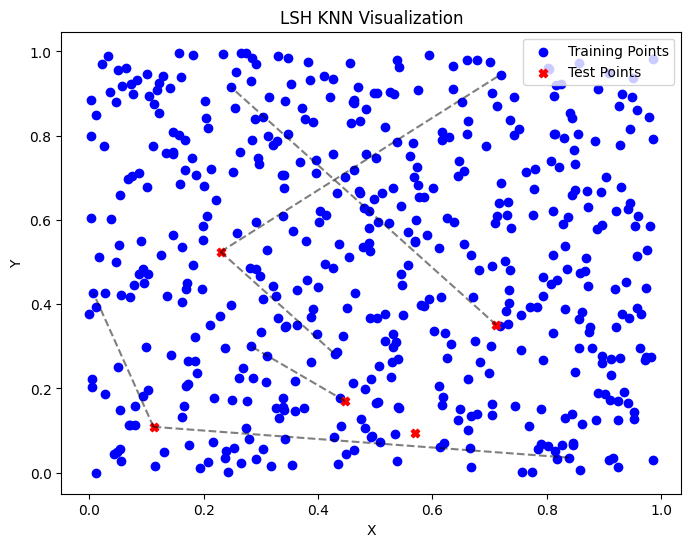

In [4]:
# Main Execution
if __name__ == "__main__":
    N_list = [50, 200, 500]  # Dataset sizes to test
    D = 2  # Number of dimensions
    K = 5  # Number of neighbors

    # Performance Comparison
    results = compare_knn_variants_with_timing([50, 200, 500], 2, 5)

    print(f"{'N':<10}{'Naive Train':<15}{'Naive Test':<15}{'KD-Tree Train':<15}{'KD-Tree Test':<15}{'LSH Train':<15}{'LSH Test':<15}")
    for result in results:
        print(f"{result['N']:<10}{result['naive_train_time']:<15.4f}{result['naive_test_time']:<15.4f}"
            f"{result['kd_train_time']:<15.4f}{result['kd_test_time']:<15.4f}"
            f"{result['lsh_train_time']:<15.4f}{result['lsh_test_time']:<15.4f}")


    # Visualization for the largest dataset
    N = max(N_list)
    X_train = generate_data(N, D)
    X_test = generate_data(5, D)

    # Visualize Naive KNN
    naive_neighbors = naive_knn(X_train, X_test, K)
    visualize_neighbors_and_partitions(X_train, X_test, naive_neighbors, "Naive")

    # Visualize KD-Tree KNN
    kd_neighbors = kd_tree_knn(X_train, X_test, K)
    visualize_neighbors_and_partitions(X_train, X_test, kd_neighbors, "KD-Tree")

    # Visualize LSH KNN
    lsh_neighbors = lsh_knn(X_train, X_test, K)
    visualize_neighbors_and_partitions(X_train, X_test, lsh_neighbors, "LSH")


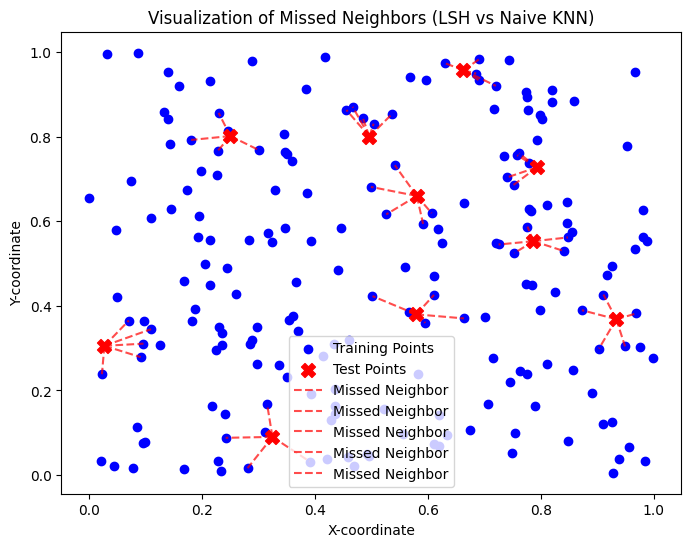

In [ ]:
def visualize_missed_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors):
    plt.figure(figsize=(8, 6))
    
    # Plot training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Points')
    
    # Plot test points
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', s=100, label='Test Points')
    
    for test_idx, test_point in enumerate(X_test):
        naive_set = set(naive_neighbors[test_idx])
        lsh_set = set(lsh_neighbors[test_idx])
        
        # Correctly identified neighbors
        correct_neighbors = list(naive_set & lsh_set)
        for neighbor_idx in correct_neighbors:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'g--', alpha=0.7, label='Correct Neighbor' if test_idx == 0 else "")
        
        # Missed neighbors
        missed_neighbors = list(naive_set - lsh_set)
        for neighbor_idx in missed_neighbors:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'r--', alpha=0.7, label='Missed Neighbor' if test_idx == 0 else "")
    
    plt.title(f"Visualization of Missed Neighbors (LSH vs Naive KNN)")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Generate a 2D dataset
    X_train = generate_data(200, 2)  # 100 training points in 2D
    X_test = generate_data(10, 2)    # 5 test points in 2D
    K = 5  # Number of neighbors

    # Compute neighbors using Naive KNN (exact)
    naive_neighbors = naive_knn(X_train, X_test, K)

    # Compute neighbors using LSH KNN (approximate)
    lsh_neighbors = lsh_knn(X_train, X_test, K)

    # Visualize missed neighbors
    visualize_missed_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors)


In [6]:
for test_idx, test_point in enumerate(X_test):
    naive_set = set(naive_neighbors[test_idx])
    lsh_set = set(lsh_neighbors[test_idx])
    correct_neighbors = naive_set & lsh_set
    missed_neighbors = naive_set - lsh_set
    print(f"Test Point {test_idx}: Correct={len(correct_neighbors)}, Missed={len(missed_neighbors)}")


Test Point 0: Correct=0, Missed=5
Test Point 1: Correct=0, Missed=5
Test Point 2: Correct=0, Missed=5
Test Point 3: Correct=0, Missed=5
Test Point 4: Correct=0, Missed=5
Test Point 5: Correct=0, Missed=5
Test Point 6: Correct=0, Missed=5
Test Point 7: Correct=0, Missed=5
Test Point 8: Correct=0, Missed=5
Test Point 9: Correct=0, Missed=5


In [ ]:
def visualize_missed_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors):
    plt.figure(figsize=(8, 6))
    
    # Plot training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label='Training Points')
    
    # Plot test points
    plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='X', s=100, label='Test Points')
    
    for test_idx, test_point in enumerate(X_test):
        naive_set = set(naive_neighbors[test_idx])
        lsh_set = set(lsh_neighbors[test_idx])
        
        # Correctly identified neighbors
        correct_neighbors = list(naive_set & lsh_set)
        missed_neighbors = list(naive_set - lsh_set)

        for neighbor_idx in correct_neighbors:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'g--', alpha=0.7, label='Correct Neighbor' if test_idx == 0 else "")
        
        for neighbor_idx in missed_neighbors:
            plt.plot([test_point[0], X_train[neighbor_idx, 0]],
                     [test_point[1], X_train[neighbor_idx, 1]], 'r--', alpha=0.7, label='Missed Neighbor' if test_idx == 0 else "")

        # Debug labels
        plt.text(test_point[0], test_point[1], f'TP{test_idx}', color='red', fontsize=8)
        for neighbor_idx in correct_neighbors:
            plt.text(X_train[neighbor_idx, 0], X_train[neighbor_idx, 1], f'CN', color='green', fontsize=8)
        for neighbor_idx in missed_neighbors:
            plt.text(X_train[neighbor_idx, 0], X_train[neighbor_idx, 1], f'MN', color='orange', fontsize=8)

    plt.title(f"Visualization of Missed Neighbors (LSH vs Naive KNN)")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.show()

# Example Execution
if __name__ == "__main__":
    # Generate a 2D dataset
    X_train = generate_data(200, 2)  # 100 training points in 2D
    X_test = generate_data(5, 2)    # 5 test points in 2D
    K = 5  # Number of neighbors

    # Compute neighbors using Naive KNN (exact)
    naive_neighbors = naive_knn(X_train, X_test, K)

    # Compute neighbors using LSH KNN (approximate)
    lsh_neighbors = lsh_knn(X_train, X_test, K)

    # Visualize missed neighbors
    visualize_missed_neighbors(X_train, X_test, K, naive_neighbors, lsh_neighbors)
